# Anomaly detection using pyOD

In [57]:
from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

In [58]:
from google.colab import files
uploaded = files.upload()


Saving catfish.csv to catfish (1).csv


##Catfish Sales Dataset

In [59]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

#read data
catfish_sales = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0, date_parser=parser)

In [60]:
#infer the frequency of the data
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

### Introduce an Anomaly

In [61]:
import datetime
idx = pd.IndexSlice

In [62]:
catfish_sales.loc["1998-12-1"]['Total'] = 10000

In [63]:
from datetime import datetime

start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

In [64]:
lim_catfish_sales

,Total
Date,
1996-01-01,20322
1996-02-01,20613
1996-03-01,22704
1996-04-01,20276
1996-05-01,20669
...,...
1999-09-01,24430
1999-10-01,25229
1999-11-01,22344


In [65]:
#At December 1 1998
lim_catfish_sales.iloc[0]

,1996-01-01
Total,20322


In [66]:
lim_catfish_sales

,Total
Date,
1996-01-01,20322
1996-02-01,20613
1996-03-01,22704
1996-04-01,20276
1996-05-01,20669
...,...
1999-09-01,24430
1999-10-01,25229
1999-11-01,22344


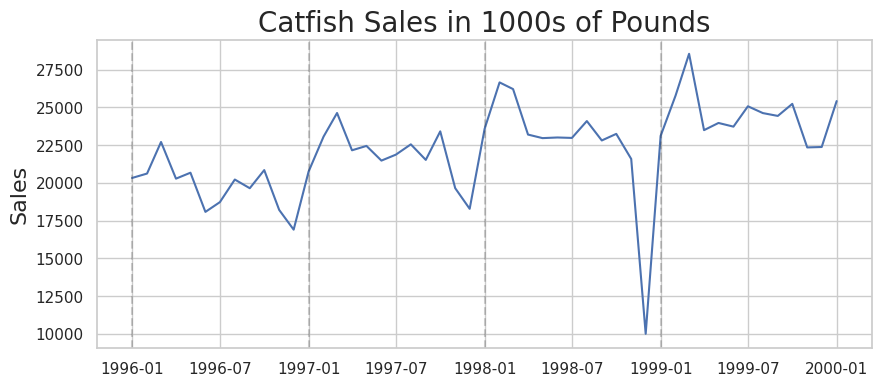

In [67]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Seasonal Decompose

In [68]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

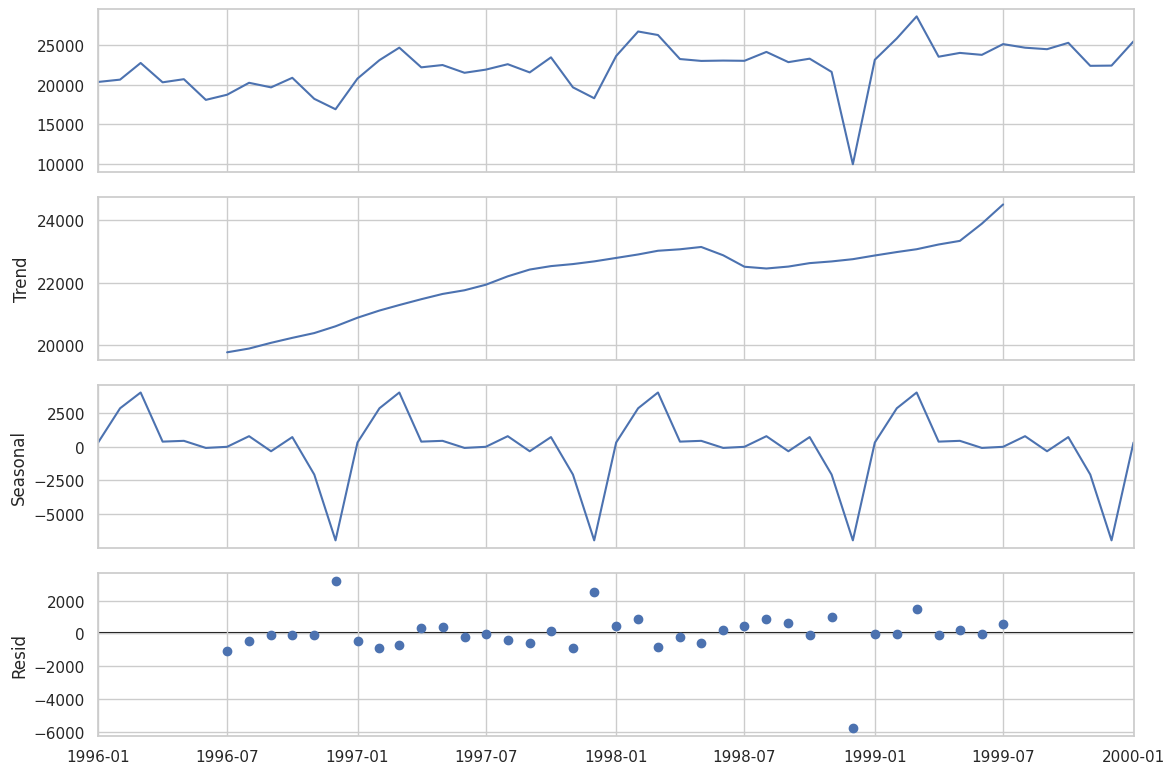

In [69]:
plt.rc('figure',figsize=(12,8))
plt.rc('font',size=15)

result = seasonal_decompose(lim_catfish_sales,model='additive')
fig = result.plot()

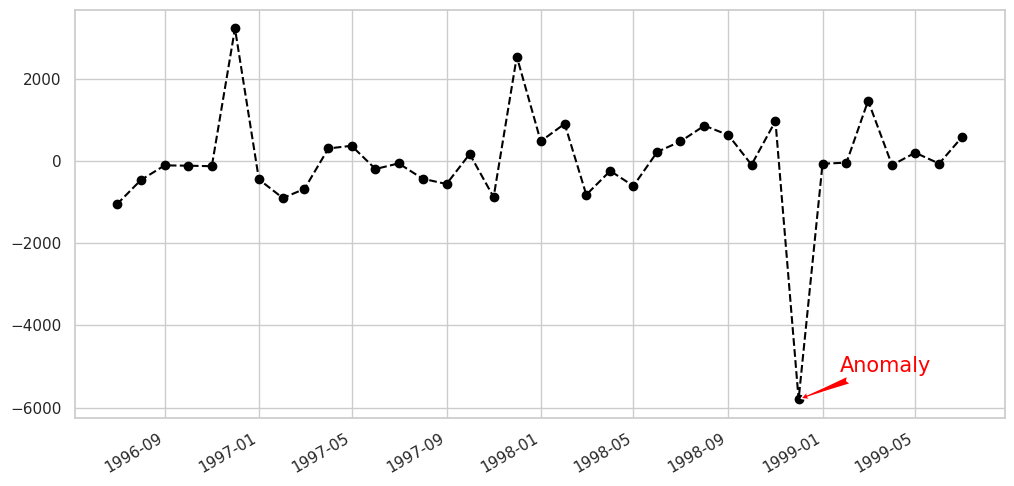

In [70]:
plt.rc('figure',figsize=(12,6))
plt.rc('font',size=15)

fig, ax = plt.subplots()
x = result.resid.index
y = result.resid.values
ax.plot_date(x, y, color='black',linestyle='--')

ax.annotate('Anomaly', (mdates.date2num(x[35]), y[35]), xytext=(30, 20),
           textcoords='offset points', color='red',arrowprops=dict(facecolor='red',arrowstyle='fancy'))

fig.autofmt_xdate()
plt.show()

### Introduce some more point outliers

In [71]:
catfish_sales.loc["1993-3-1"]['Total'] = 30000
catfish_sales.loc["2003-3-1"]['Total'] = 35000

## Isolation forest

In [72]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

<Axes: xlabel='Date'>

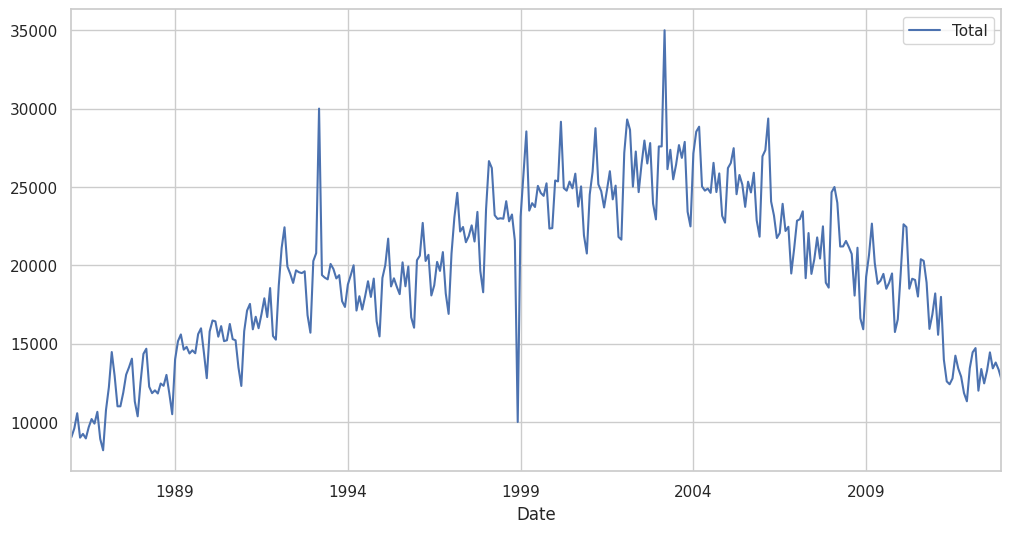

In [73]:
plt.rc('figure',figsize=(12,6))
plt.rc('font',size=15)
catfish_sales.plot()

In [74]:
outliers_fraction = float(.01)
scaler = StandardScaler()
np_scaled = scaler.fit_transform(catfish_sales.values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)

# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)

IsolationForest(contamination=0.01)

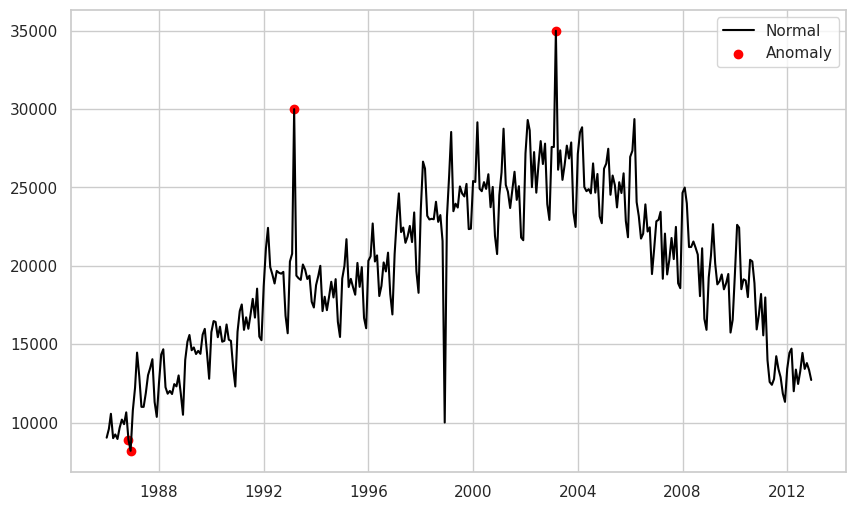

In [75]:
catfish_sales['anomaly'] = model.predict(data)

# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = catfish_sales.loc[catfish_sales['anomaly'] == -1, ['Total']] #anomaly

ax.plot(catfish_sales.index, catfish_sales['Total'], color='black', label = 'Normal')
ax.scatter(a.index,a['Total'], color='red', label = 'Anomaly')
plt.legend()
plt.show();